In [2]:
import pandas as pd
import pylab as plt
import seaborn
import numpy as np
import re
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
%pylab inline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

Populating the interactive namespace from numpy and matplotlib


In [3]:
#  Implementation of the F4 Algorithm in Sage
#  [1]  Jean-Charles Faugere. A new efficient algorithm for computing Groebner bases (F4). Journal of pure and applied algebra, 139(1–3):61–88, July 1999.
#  [2]  Alessandro Giovini, Teo Mora, Gianfranco Niesi, Lorenzo Robbiano, Carlo Traverso. "One sugar cube, please "or Selection strategies in the Buchberger algorithm"".

########################################
#  Create a pair from two polynomials  #
########################################
#  [1] Definition 2.5, page 5

def Pair(f, g):
    try:
        lcm = (f.lm()).lcm(g.lm())
        return (lcm, lcm // f.lm(), f, lcm // g.lm(), g)
    except ZeroDivisionError:
        raise Exception()

########################################
#   Function adds new pairs to Pairs (f, g) where f belongs to new (set of polynomials),
#   g belongs to basis (temporary basis Gr. already found up to this point)
########################################

def FirstBuchbergerCriterion(f, g):
    if (f.lm()).gcd(g.lm()) == 1:
        return True
    return False

'''
def SecondBuchbergerCriterion(f, g, basis, pairs):
    isReducible, h = IsTopReducible((f.lm()).lcm(g.lm()), basis)
    if isReducible:
        if Pair(f, h) in pairs and Pair(g, h) in pairs:
            return True
    return False

def BuchbergerCriteria(f, g, basis, Pairs):
    if FirstBuchbergerCriterion(f, g) and SecondBuchbergerCriterion(f, g, basis, pairs):
        return True
    return False
'''

def Update(basis, pairs, new):
    try:
        basis += new
        basis = uniq(basis)
        for f in new:
            for g in basis:
                if f != g and Pair(g, f) not in pairs:
                    if not FirstBuchbergerCriterion(f, g):
                        pairs.append(Pair(f, g))
        result = [basis, pairs]
        return result
    except Exception:
        print "basis = ", basis
        for elem in basis:
            print elem.parent()

##############################################
#  Selection function - the normal strategy  #
##############################################
#  [1] function Sel, page 13

def LCM(pair):
    return pair[0]

def SelectionFunctionNormal(pairs):
    d = min([LCM(p).degree() for p in pairs])
    dPairs = [p for p in pairs if LCM(p).degree() == d]
    return dPairs

##############################################
#  Selection function - take all pairs  #
##############################################

def SelectionFunctionAll(pairs):
    return pairs

############################
#  Symbolic Preprocessing  #
############################
#  [1] Symbolic Preprocessing, page 7
#  for this procedure better see http://www.broune.com/papers/f4.pdf
#  page 2, instead of the original paper

def IsTopReducible(f, G):
    m = f.lm()
    for g in G:
        if g.lm().divides(m):
             return True, g
    return False, 0

def SymbolicPreprocessing(L, G):
    F = []
    for Li in L:
        F.append(Li[0] * Li[1])
    done = set([f.lt() for f in F])
    TF = set()
    for f in F:
        TF |= set(f.monomials())

    while len(TF) > 0:
        m = TF.pop()
        done.add(m)
        isReducible, f = IsTopReducible(m, G)
        if isReducible:
            mDash = m // f.lm()
            F.append(mDash * f)
            newMonomials = (mDash * f).monomials()
            newMonomials.remove(newMonomials[0])
            TF |= set(newMonomials)
            TF -= done
    return F

###############
#  Reduction  #
###############
#  [1] Reduction, page 6

def Reduction(L, G):
    F = SymbolicPreprocessing(L, G)

    leadingMonomials = set()
    for f in F:
        leadingMonomials.add(f.lm())

    monomials = set()
    for f in F:
        monomials |= set(f.monomials())

    monomials = list(monomials)
    monomials.sort(reverse = True)

    M = Matrix(len(F), len(monomials), lambda i, j: F[i].monomial_coefficient(monomials[j]), sparse = True)
    M.echelonize()
    polynomialsAfterEchelonize = []

    for i in range(M.nrows()):
        f = 0
        for j in range(M.ncols()):
            f += M[i, j] * monomials[j]
        if f != 0 and f.lm() not in leadingMonomials:
            polynomialsAfterEchelonize.append(f)

    return polynomialsAfterEchelonize

def IsReducible(f, F):
    if F == []:
        return False, 0
    f1 = f.reduce(F)
    if f1 != f:
        return True, f1
    return False, 0

def ReductionOfBasis(F):
    i = 0
    while i < len(F):
        if F[i] != 0:
            G = []
            for j in range (len(F)):
                if j != i:
                    if F[j] != 0:
                        G.append(F[j])
            (t, g) = IsReducible(F[i], G)
            if t:
                F[i] = g
                i = -1
        i += 1
    G = []
    for j in range (len(F)):
        if F[j] != 0:
            G.append(F[j] / F[j].lc())
    return G

#######################################
#  Main function of the F4 Algorithm  #
#######################################
#  [1] Algorithm F4, page 6

def F4(polynomials, strategy):
    (basis, pairs) = Update([], [], polynomials)
    howManySteps = 0

    while len(pairs) > 0:
        howManySteps += 1

        if (strategy == 'normal'):
            pairsSel = SelectionFunctionNormal(pairs)
        else:
            pairsSel = SelectionFunctionAll(pairs)
        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        new = Reduction(Ld, basis)
        (basis, pairs) = Update(basis, pairs, new)

    return ReductionOfBasis(basis), howManySteps


def Spol(f, g):
    h = (f.lm()).lcm(g.lm())
    return g.lc() * h * f // f.lm() - f.lc() * h * g // g.lm()

def is_groebner_basis(G):
    if G == []:
        return False
    R = G[0].parent()
    for i in xrange(len(G)) :
        f = G[i]
        for j in xrange(i, len(G)) :
            g = G[j]
            if (Spol(f, g)).reduce(G) != R(0) :
                return False
    return True

def LaunchF4(n):
    for i in range (n):
        generators = GetRandomGeneratorsForIdeal(4, 4, 4)
        while 0 in generators:
            print "Zero in generators"
            generators = GetRandomGeneratorsForIdeal(4, 4, 4)
        basis, steps = F4(generators, 'all')
        if not is_groebner_basis(basis):
            print "error, system = ", generators

#######################################
#         MACHINE LEARNING            #
#######################################

def Print(numOfObjects, i):
    if numOfObjects <= 30:
        print "Object No: ", i
    elif numOfObjects <= 100 and i % 10 == 0:
        print "Object No: ", i
    elif numOfObjects <= 3000 and i % 50 == 0:
        print "Object No: ", i
    elif numOfObjects <= 6000 and i % 100 == 0:
        print "Object No: ", i

def GetFeatures(generators):
    features = {}
    R = generators[0].parent()
    features["number of variables"] = R.ngens()
    features["number of generators"] = len(generators)
    features["max number of monomials"] = max([len(p.monomials()) for p in generators])
    features["min number of monomials"] = min([len(p.monomials()) for p in generators])
    features["max degree of generators"] = max([f.degree() for f in generators])
    features["min degree of generators"] = min([f.degree() for f in generators])
    features["ideal is homogeneous"] = int(R.ideal(generators).is_homogeneous())
    return features

def GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1):
    nVar = np.random.randint(minVar, maxVar)
    nElem = np.random.randint(minElem, maxElem)

    R = PolynomialRing(QQ, 'x', nVar)
    # R = PolynomialRing(GF(2), 'x', nVar)
    generators = []

    if nVar + nElem % 2 == 1:
        R = (R.gens()[0] + 1).homogenize().parent()     # if we apply .homognize() to a homogeneous polynomial it's parent ring won't change
                                                        # but we want to have a unique parent for all generators
    for i in range(nElem):
        deg = np.random.randint(minDeg, maxDeg)
        randomPol = R.random_element(degree = deg)

        while randomPol == R(0):

            randomPol = R.random_element(degree = deg)

        if nVar + nElem % 2 == 1:    # just a random criteria for a homogeneous ideal to appear
            generators.append(R(randomPol.homogenize()))
        else:
            generators.append(randomPol)
    return generators

def MakeDataSet(allFeatures):
    indices = [i for i in range(len(allFeatures))]
    data = {}
    for key in allFeatures[0].keys():
        data[key] = pd.Series([f[key] for f in allFeatures], index = indices)

    df = pd.DataFrame(data)
    return df

def GenerateDataSet(numOfObjects, maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1):
    allFeatures = []
    whichStrategyIsBetter = []

    for i in range (numOfObjects):
        Print(numOfObjects, i)

        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)

        features = GetFeatures(generators)

        basis, howManyStepsN = F4(generators, 'normal')
        basis, howManyStepsAll = F4(generators, 'all')

        if howManyStepsN <= howManyStepsAll:
            features['better strategy: 1 - normal, 0 - all'] = 1
        else:
            features['better strategy: 1 - normal, 0 - all'] = 0

        allFeatures.append(features)

    return MakeDataSet(allFeatures)

def GetFeatureImportances(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

    clf = RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state = 42)
    clf = clf.fit(X_train, y_train)

    importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
    importances = importances.sort_values('importance',ascending=False).set_index('feature')
    print importances
    importances.plot.bar()

def TrainAndShowMetrics(X, y, classOne, classTwo, clf, transform = False):
    print "Classifier:\n"
    print clf
    print "\n"
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

    if transform:
        print "After StandardScaler\n"
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        clf.fit(X_train, y_train)
        X_test = scaler.transform(X_test)
        pred = clf.predict(X_test)

    else:
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

    print "accuracy = {} \n".format(metrics.accuracy_score(y_test, pred))

    target_names = [classOne, classTwo]

    print classification_report(y_test, pred, target_names = target_names)

    predprob = clf.predict_proba(X_test)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, predprob[:, 1])
    plt.plot(fpr, tpr)
    plt.title('ROC-curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    print 'AUC-ROC:', metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, predprob[:, 1])
    plt.plot(recall, precision)
    plt.title('Precision-Recall-curve')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.show()

    print "AUC-PR: ", metrics.auc(recall, precision)

def GetMaxDegreeByVariable(polynomials, variable):
    maxDegVar = max([pol.degree(variable) for pol in polynomials])

def GetIdealFeatures(generators, featureVector):
    R = generators[0].parent()
    featureVector["number of variables in parent ring"] = R.ngens()
    featureVector["number of generators"] = len(generators)
    featureVector["max number of monomials in generators"] = max([len(p.monomials()) for p in generators])
    featureVector["min number of monomials in generators"] = min([len(p.monomials()) for p in generators])
    featureVector["max degree of generators"] = max([f.degree() for f in generators])
    featureVector["min degree of generators"] = min([f.degree() for f in generators])

def GetPolynomialFeatures(polynomial, polynomialName, featureVector):
    R = polynomial.parent()
    X = R.gens()
    featureVector["number of variables for " + polynomialName] = R.ngens()
    featureVector["number of monomials for " + polynomialName] = len(polynomial.monomials())
    featureVector["min degree by variable for " + polynomialName] = min([polynomial.degree(variable) for variable in X])
    featureVector["max degree by variable for " + polynomialName] = max([polynomial.degree(variable) for variable in X])
    featureVector["full degree for " + polynomialName] = polynomial.degree()
    featureVector["lt degree for " + polynomialName] = polynomial.lt().degree()

def GetPairFeatures(pair, basis, featureVector):
    leftPolynomial, rightPolynomial = pair[2], pair[4]
    leftX = leftPolynomial.parent().gens()
    rightX = rightPolynomial.parent().gens()

    featureVector["lcm degree"] = pair[0].degree()
    GetIdealFeatures(basis, featureVector)
    GetPolynomialFeatures(leftPolynomial, "left polynomial", featureVector)
    GetPolynomialFeatures(rightPolynomial, "right polynomial", featureVector)

def Spol(f, g):
    h = (f.lm()).lcm(g.lm())
    return g.lc() * h * f // f.lm() - f.lc() * h * g // g.lm()

def GetData(pairs, basis, allFeatures):
    for pair in pairs:
        featureVector = {}
        GetPairFeatures(pair, basis, featureVector)
        if Spol(pair[2], pair[4]).reduce(basis) == 0:
            featureVector["should be taken"] = 0
        else:
            featureVector["should be taken"] = 1
        allFeatures.append(featureVector)

def F4_data(polynomials, allFeatures):
    (basis, pairs) = Update([], [], polynomials)

    while len(pairs) > 0:
        pairsSel = SelectionFunctionAll(pairs)
        GetData(pairs, basis, allFeatures)

        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        Fdtplus = Reduction(Ld, basis)
        (basis, pairs) = Update(basis, pairs, Fdtplus)

    return ReductionOfBasis(basis)

def CreateDataSetForNewStrategy(approximateNumOfObjects, maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1):
    allFeatures = []
    counter = 0
    while len(allFeatures) < approximateNumOfObjects:
        if counter % 100 == 0:
            print "Current number of objects: ", len(allFeatures)
        counter += 1
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        F4_data(generators, allFeatures)
    return MakeDataSet(allFeatures)

def SelectionFunctionMachineLearning(pairs, basis, clf):
    selPairs = []
    allFeatures = []
    for pair in pairs:
        featureVector = {}
        GetPairFeatures(pair, basis, featureVector)
        allFeatures.append(featureVector)

    data = MakeDataSet(allFeatures)
    pred = clf.predict(data)
    for i in range(len(pairs)):
        if pred[i] == 1:
            selPairs.append(pairs[i])
    return selPairs

#########################################################

def GetPairFeaturesInF4(pair, basis):
    leftPolynomial, rightPolynomial = pair[2], pair[4]
    parentR = basis[0].parent()
    leftX = leftPolynomial.parent().gens()
    rightX = rightPolynomial.parent().gens()

    featureVector = [
        pair[0].degree(),
        parentR.ngens(),
        len(basis),
        max([len(p.monomials()) for p in basis]),
        min([len(p.monomials()) for p in basis]),
        max([f.degree() for f in basis]),
        min([f.degree() for f in basis]),
        leftPolynomial.parent().ngens(),
        len(leftPolynomial.monomials()),
        min([leftPolynomial.degree(variable) for variable in leftX]),
        max([leftPolynomial.degree(variable) for variable in leftX]),
        leftPolynomial.degree(),
        leftPolynomial.lt().degree(),
        rightPolynomial.parent().ngens(),
        len(rightPolynomial.monomials()),
        min([rightPolynomial.degree(variable) for variable in rightX]),
        max([rightPolynomial.degree(variable) for variable in rightX]),
        rightPolynomial.degree(),
        rightPolynomial.lt().degree(),
    ]

    return featureVector

def SelectionFunctionMachineLearningNew(pairs, basis, clf):
    selPairs = []
    allFeatures = []
    for pair in pairs:
        allFeatures.append(GetPairFeaturesInF4(pair, basis))

    pred = clf.predict(np.array(allFeatures))
    for i in range(len(pairs)):
        if pred[i] == 1:
            selPairs.append(pairs[i])
    return selPairs

def F4_ML(polynomials, strategy, clf):
    (basis, pairs) = Update([], [], polynomials)
    howManySteps = 0

    while len(pairs) > 0:
        howManySteps += 1

        if (strategy == 'normal'):
            pairsSel = SelectionFunctionNormal(pairs)
        elif (strategy == 'ML'):
            pairsSel = SelectionFunctionMachineLearningNew(pairs, basis, clf)
            if len(pairsSel) == 0:
                if is_groebner_basis(basis):
                    return ReductionOfBasis(basis), howManySteps
                else:
                    # print "empty set"
                    # pairsSel = SelectionFunctionAll(pairs)
                    pairsSel = SelectionFunctionNormal(pairs)
        else:
            pairsSel = SelectionFunctionAll(pairs)
        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        new = Reduction(Ld, basis)
        (basis, pairs) = Update(basis, pairs, new)

    return ReductionOfBasis(basis), howManySteps

def LaunchF4_iterations(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf):
    numOfIterations = [[], []]

    for i in range (n):
        Print(n, i)
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)

        basis, numOfStepsNormal = F4_ML(generators, stratOne, clf)
        numOfIterations[0].append(numOfStepsNormal)

        basis, numOfStepsML = F4_ML(generators, stratTwo, clf)
        numOfIterations[1].append(numOfStepsML)

    return numOfIterations

def DrawDiagramForIterations(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf):
    strategies = [stratOne, stratTwo]
    numOfIterations =  LaunchF4_iterations(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf)
    indices = [i for i in range(n)]

    plt.figure(figsize=(12, 5))

    for i in range (2):
        plt.plot(indices, numOfIterations[i], label = '{}, sum of iterations = {}'.format(strategies[i], sum(numOfIterations[i])))

    plt.title('Iterations for {} and {} strategies'.format(stratOne, stratTwo), fontsize = 16, y = 1.02)
    plt.xlabel('Number of experiment')
    plt.ylabel('Number of iterations')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2)
    
from time import time

def PrintResultsForStrategies(times, stratOne, stratTwo):
    print "\n"
    print "Mean time:"
    print stratOne, ": ", np.mean(times[0]), ", ", stratTwo, ": ", np.mean(times[1])

    # print "\n"
    print "Max time:"
    print stratOne, ": ", max(times[0]), ", ", stratTwo, ": ", max(times[1])

    # print "\n"
    print "Min time:"
    print stratOne, ": ", min(times[0]), ", ", stratTwo, ": ", min(times[1])
    print "\n"

def LaunchF4_time_ML(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf):
    times = [[], []]
    timesWhenFirstStratBetter = 0
    timesWhenSecondStratBetter = 0

    for i in range (n):
        Print(n, i)
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)

        t1 = time()
        F4_ML(generators, stratOne, clf)
        t1 = time() - t1
        times[0].append(t1)

        t2 = time()
        F4_ML(generators, stratTwo, clf)
        t2 = time() - t2
        times[1].append(t2)

        if t1 > t2:
            timesWhenSecondStratBetter += 1
        else:
            timesWhenFirstStratBetter += 1
    print "\ntimes when {} is better: ".format(stratOne), timesWhenFirstStratBetter
    print "times when {} is better: ".format(stratTwo), timesWhenSecondStratBetter

    PrintResultsForStrategies(times, stratOne, stratTwo)
    return times

def DrawDiagramForTime(stratOne, stratTwo, times):
    strategies = [stratOne, stratTwo]
    # times =  LaunchF4_time_ML(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf)

    indices = [i for i in range(len(times[0]))]
    plt.figure(figsize=(12, 5))

    for i in range (2):
        plt.plot(indices, times[i], label = '{}'.format(strategies[i]))

    plt.title('Time for {} and {} strategies'.format(stratOne, stratTwo), fontsize = 16, y = 1.02)
    plt.xlabel('Number of experiment')
    plt.ylabel('Time')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2)

## Стратегия, основанная на машинном обучении 

Попробуем научиться выбирать S-пары, основываясь на машинном обучении. Будем считать S-пару хорошей, если она не редуцируется относительно текущего базиса (т.е. элементов базиса, найденных на данной итерации) к нулю, и плохой в противном случае. Для sPair(f, g) будем называть левым и правым полиномы f и g соответственно. Признаки у S-пары f и g будут состоять из признаков для обоих полиномов и признаков текущего базиса:
1. Степень НОК(f.lm(), g.lm())

(каждый следующий признак берётся и для левого, и для правого полиномов)

2. Степень полинома (полная).
3. Степень старшего монома.
4. Количество мономов.
5. Количество переменных.
6. Максимальная степень по переменной.
7. Минимальная степень по переменной.

(следующие признаки берутся для идеала, порождённого текущим базисом)

8. Число переменных в кольце-родителе.
9. Число порождающих в идеале.
10. Максимальная длина порождающего полинома (длина := число мономов).
11. Минимальная длина порождающего полинома.
12. Максимальная степень порождающего (полная, то есть наибольшая степень входящего в него монома).
13. Минимальная степень порождающего.

Всего признаков вышло 19. Для датасета будем запускать F4 до тех пор, пока суммарно за все запуски не будет рассмотрено количество S-пар не меньше некоторого заданного.

Создадим датасет, содержащий 10 000 объектов (то есть векторы признаков для 10 000 пар). Для системы порождающих, на которых будет запускаться F4, ограничения будут такими: число переменных <= 4, число порождающих <= 5, степени порождающих <= 5.

In [4]:
%time df_newstrat = CreateDataSetForNewStrategy(approximateNumOfObjects = 10000, maxVar = 4, maxElem = 5, maxDeg = 5)

Current number of objects:  0


Current number of objects:  2065


Current number of objects:  5630


Current number of objects:  9998


CPU times: user 1min 14s, sys: 303 ms, total: 1min 14s
Wall time: 1min 16s


In [5]:
df_newstrat.head()

,full degree for left polynomial,full degree for right polynomial,lcm degree,lt degree for left polynomial,lt degree for right polynomial,max degree by variable for left polynomial,max degree by variable for right polynomial,max degree of generators,max number of monomials in generators,min degree by variable for left polynomial,min degree by variable for right polynomial,min degree of generators,min number of monomials in generators,number of generators,number of monomials for left polynomial,number of monomials for right polynomial,number of variables for left polynomial,number of variables for right polynomial,number of variables in parent ring,should be taken
0,2,3,3,2,3,2,3,4,4,2,3,2,2,3,2,4,1,1,1,1
1,2,4,4,2,4,2,4,4,4,2,4,2,2,3,2,4,1,1,1,1
2,4,3,4,4,3,4,3,4,4,4,3,2,2,3,4,4,1,1,1,1
3,1,2,2,1,2,1,2,4,4,1,2,0,1,5,1,2,1,1,1,0
4,1,3,3,1,3,1,3,4,4,1,3,0,1,5,1,4,1,1,1,0


Посмотрим, насколько сбалансированы классы пар.

In [6]:
df_newstrat['should be taken'].value_counts()

0    5832
1    4196
Name: should be taken, dtype: int64

Видно, что нет высокого преобладания одного класса над другим, и это хорошо, потому что классификаторы тогда не могут настроиться на доминирующий класс.

In [7]:
df_newstrat['should be taken'] = np.where(df_newstrat['should be taken'] == 1, 1, 0)
y_feat = df_newstrat['should be taken']
X = df_newstrat.drop('should be taken', axis = 1)
X.head()

,full degree for left polynomial,full degree for right polynomial,lcm degree,lt degree for left polynomial,lt degree for right polynomial,max degree by variable for left polynomial,max degree by variable for right polynomial,max degree of generators,max number of monomials in generators,min degree by variable for left polynomial,min degree by variable for right polynomial,min degree of generators,min number of monomials in generators,number of generators,number of monomials for left polynomial,number of monomials for right polynomial,number of variables for left polynomial,number of variables for right polynomial,number of variables in parent ring
0,2,3,3,2,3,2,3,4,4,2,3,2,2,3,2,4,1,1,1
1,2,4,4,2,4,2,4,4,4,2,4,2,2,3,2,4,1,1,1
2,4,3,4,4,3,4,3,4,4,4,3,2,2,3,4,4,1,1,1
3,1,2,2,1,2,1,2,4,4,1,2,0,1,5,1,2,1,1,1
4,1,3,3,1,3,1,3,4,4,1,3,0,1,5,1,4,1,1,1


Посмотрим на градацию важности имеющихся признаков по версии случайного леса.

                                             importance
feature                                                
max degree of generators                          0.185
number of generators                              0.180
number of monomials for left polynomial           0.151
min number of monomials in generators             0.128
max number of monomials in generators             0.094
min degree of generators                          0.044
number of monomials for right polynomial          0.035
lcm degree                                        0.034
max degree by variable for left polynomial        0.030
min degree by variable for left polynomial        0.022
lt degree for right polynomial                    0.017
max degree by variable for right polynomial       0.017
lt degree for left polynomial                     0.016
full degree for left polynomial                   0.015
full degree for right polynomial                  0.014
min degree by variable for right polynomial     

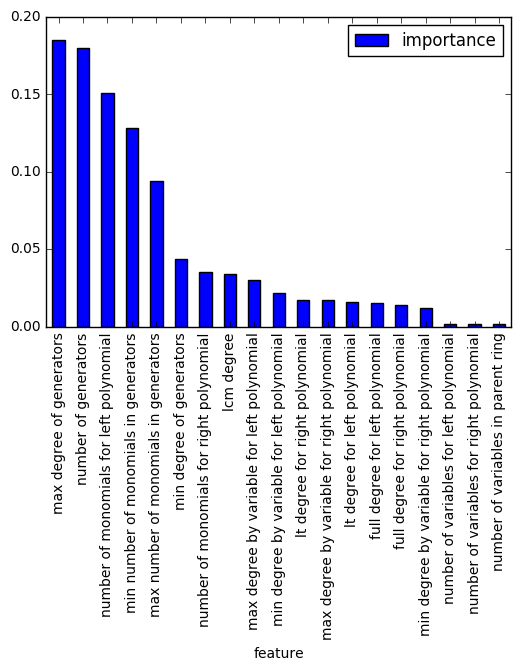

In [8]:
GetFeatureImportances(X, y_feat)

Теперь обучим и посмотрим на соответствующие метрики для SVM (разделение выборки на тестовую и обучающую, а также само обучение, происходят внутри TrainAndShowMetrics).

Classifier:

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)




accuracy = 0.96529716793 

             precision    recall  f1-score   support

 bad sPairs       0.98      0.96      0.97      1461
good sPairs       0.95      0.97      0.96      1046

avg / total       0.97      0.97      0.97      2507



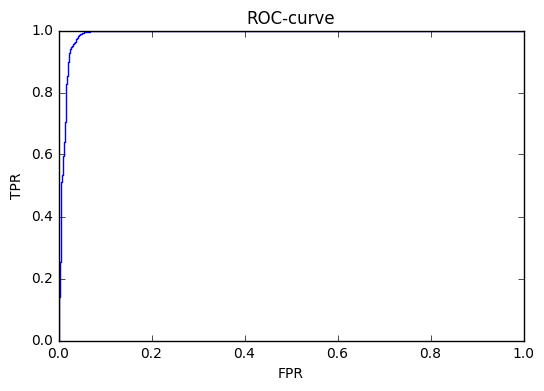

AUC-ROC: 0.988302624123


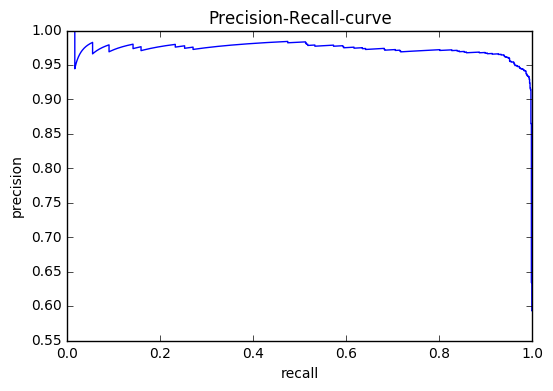

AUC-PR:  0.972924537904


In [9]:
clf = SVC(kernel = 'rbf', probability = True)

TrainAndShowMetrics(X, y_feat, 'bad sPairs', 'good sPairs', clf)

Будем выбирать S-пары, основываясь на предсказании классификатора. В функцию SelectionFunctionMachineLearning(pairs, basis, clf) передаём пары, текущий базис и классификатор. Сначала формируем признаки для каждой пары, потом формируем из них датасет и просим классификатор предсказать, нужна эта пара или нет. В соответствии с полученным вектором предсказаний берём пары (1 -- берём, 0 -- не берём). Если вдруг классификатор решил не брать ни одной пары, то проверяем, является ли текущий базис базисом Грёбнера. Если да, то останавливаемся. Если нет, то просто берём все имеющиеся пары pairs или выбираем пары с помощью нормальной стратегии.

Нарисуем графики с числом итераций при сравнении стратегии ML с normal и all.

Object No:  0


Object No:  10


Object No:  20


Object No:  30


Object No:  40


Object No:  50


Object No:  60


Object No:  70


Object No:  80


Object No:  90


CPU times: user 8.04 s, sys: 125 ms, total: 8.17 s
Wall time: 8.79 s


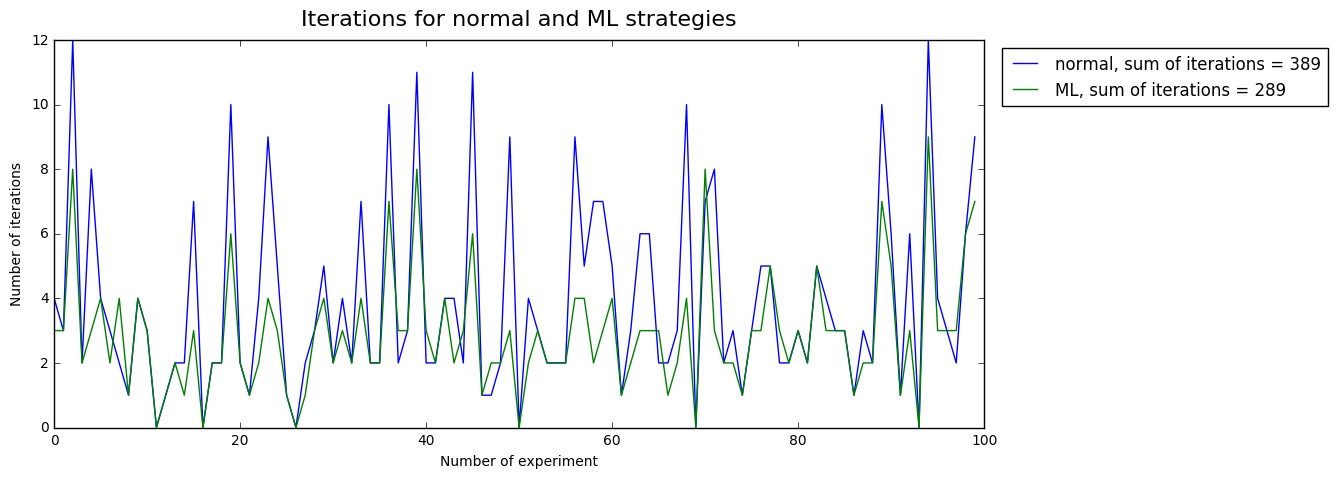

In [25]:
clf = SVC(kernel = 'rbf', probability = True)
clf.fit(X, y_feat)

%time DrawDiagramForIterations(100, 4, 5, 5, 'normal', 'ML', clf)

Object No:  0
Object No:  

10
Object No:  20


Object No:  30


Object No:  40


Object No:  50


Object No:  60


Object No:  70


Object No:  80


Object No:  90


CPU times: user 12.7 s, sys: 245 ms, total: 12.9 s
Wall time: 13.5 s


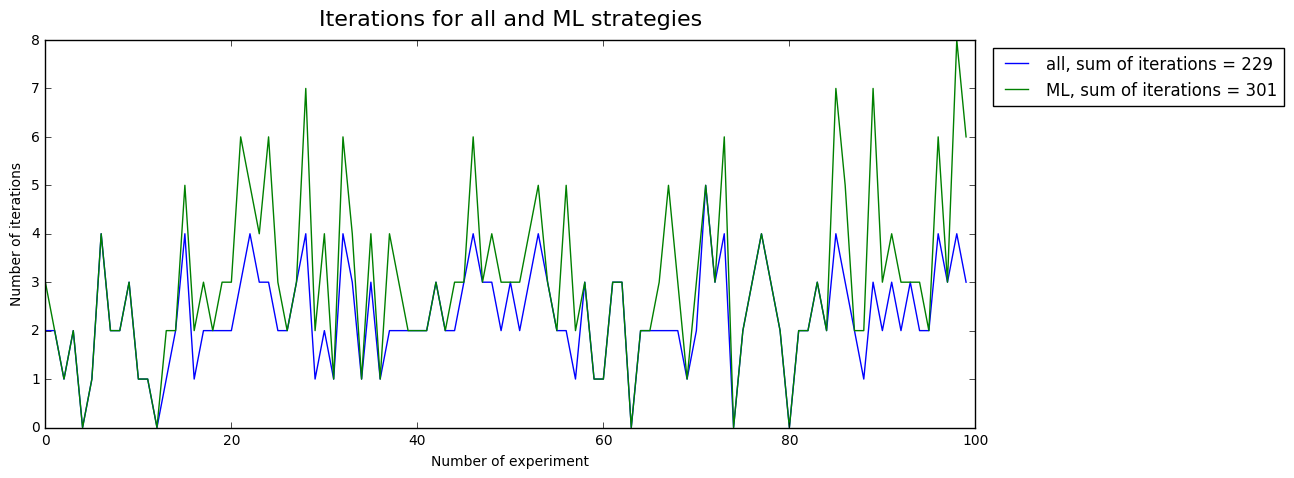

In [26]:
%time DrawDiagramForIterations(100, 4, 5, 5, 'all', 'ML', clf)

Сравним стратегии по времени. Сначала сравним ML и normal.

In [41]:
%time times =  LaunchF4_time_ML(100, 4, 5, 5, 'normal', 'ML', clf)

Object No:  0


Object No:  10


Object No:  20


Object No:  30


Object No:  40


Object No:  50


Object No:  60


Object No:  70


Object No:  80


Object No:  90



times when normal is better:  33
times when ML is better:  67


Mean time:
normal :  0.0545685982704 ,  ML :  0.0426001358032
Max time:
normal :  0.73873591423 ,  ML :  0.676413059235
Min time:
normal :  0.000139951705933 ,  ML :  9.51290130615e-05


CPU times: user 9.05 s, sys: 153 ms, total: 9.2 s
Wall time: 9.89 s


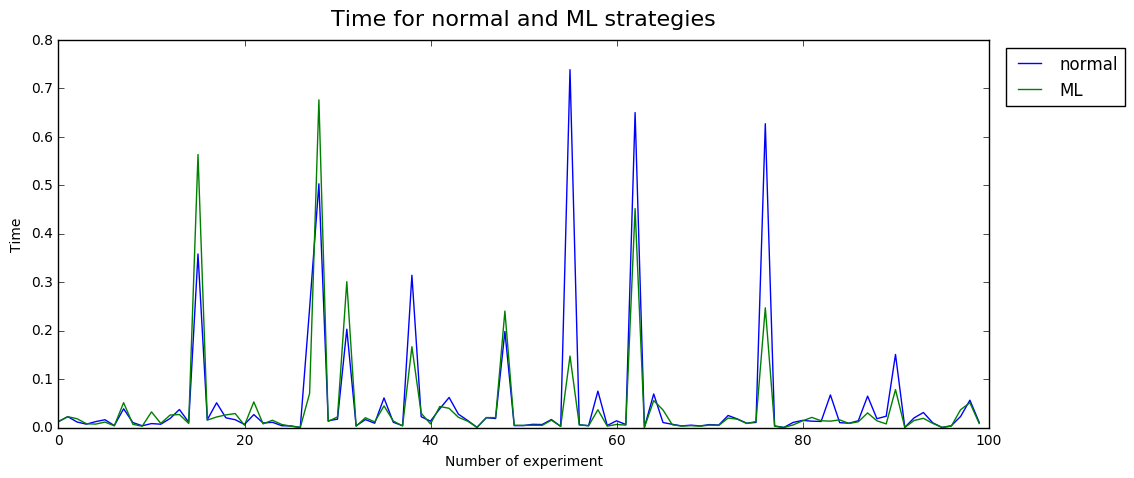

In [42]:
DrawDiagramForTime('normal', 'ML', times)

In [36]:
%time times =  LaunchF4_time_ML(1000, 4, 5, 5, 'normal', 'ML', clf)

Object No:  0


Object No:  50


Object No:  100


Object No:  150


Object No:  200


Object No:  250


Object No:  300


Object No:  350


Object No:  400


Object No:  450


Object No:  500


Object No:  550


Object No:  600


Object No:  650


Object No:  700


Object No:  750


Object No:  800


Object No:  850


Object No:  900


Object No:  950



times when normal is better:  377
times when ML is better:  623


Mean time:
normal :  0.137833316088 ,  ML :  0.0693134140968
Max time:
normal :  69.3156280518 ,  ML :  8.38569307327
Min time:
normal :  0.000132083892822 ,  ML :  9.10758972168e-05


CPU times: user 3min 20s, sys: 1.86 s, total: 3min 22s
Wall time: 3min 28s


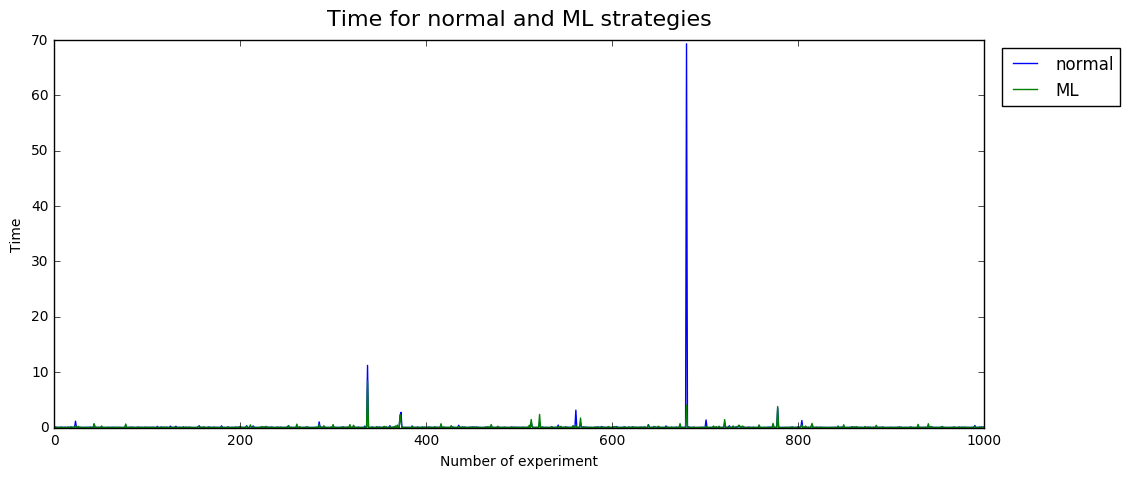

In [40]:
DrawDiagramForTime('normal', 'ML', times)

Получилось, что в первом эксперименте ML лучше по времени, чем normal, в 67 случаях из 100, а во втором эксперименте ML лучше в 623 случаях из 1000.

Теперь ML и all.

In [33]:
%time times =  LaunchF4_time_ML(100, 4, 5, 5, 'all', 'ML', clf)

Object No:  0


Object No:  10


Object No:  20


Object No:  30


Object No:  40


Object No:  50


Object No:  60


Object No:  70


Object No:  80


Object No:  90



times when all is better:  46
times when ML is better:  54


Mean time:
all :  0.145665686131 ,  ML :  0.0611706018448
Max time:
all :  6.80657196045 ,  ML :  2.36675095558
Min time:
all :  0.000202894210815 ,  ML :  0.000162124633789


CPU times: user 20.1 s, sys: 152 ms, total: 20.2 s
Wall time: 20.8 s


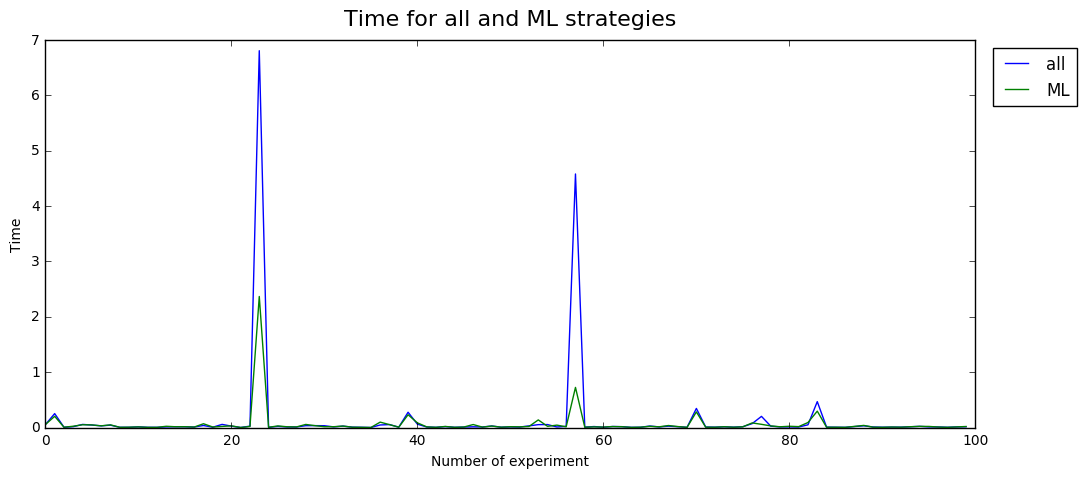

In [34]:
DrawDiagramForTime('all', 'ML', times)

In [10]:
%time times =  LaunchF4_time_ML(1000, 4, 5, 5, 'all', 'ML', clf)

Object No:  0


Object No:  50


Object No:  100


Object No:  150


Object No:  200


Object No:  250


Object No:  300


Object No:  350


Object No:  400


Object No:  450


Object No:  500


Object No:  550


Object No:  600


Object No:  650


Object No:  700


Object No:  750


Object No:  800


Object No:  850


Object No:  900


Object No:  950



times when all is better:  401
times when ML is better:  599


Mean time:
all :  0.0876387488842 ,  ML :  0.051874568224
Max time:
all :  5.75608706474 ,  ML :  2.55879807472
Min time:
all :  0.000141859054565 ,  ML :  9.89437103271e-05


CPU times: user 2min 15s, sys: 975 ms, total: 2min 16s
Wall time: 2min 20s


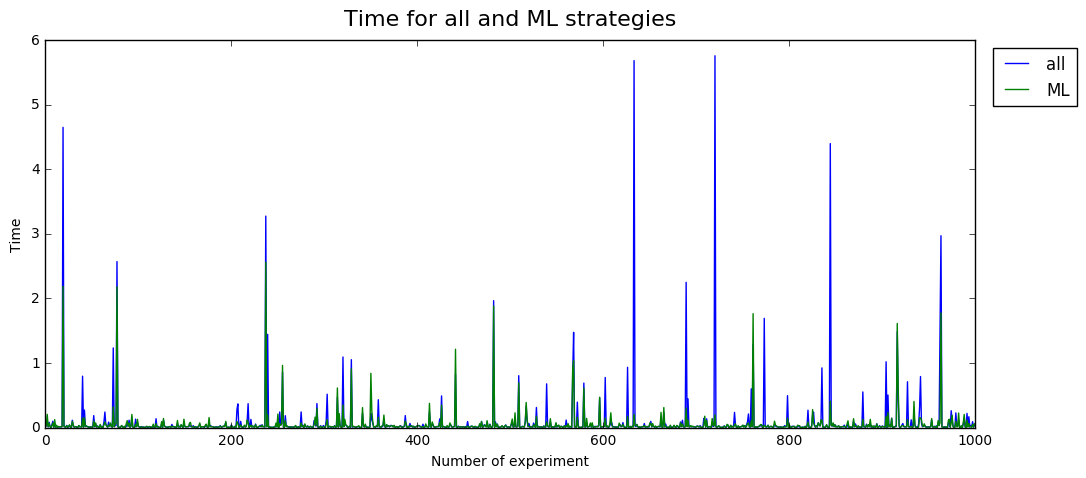

In [11]:
DrawDiagramForTime('all', 'ML', times)

Получилось, что в первом эксперименте ML лучше по времени, чем normal, в 54 случаях из 100, а во втором эксперименте ML лучше в 599 случаях из 1000.